In [ ]:
# IMPORTS
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import albumentations as A
from tqdm import tqdm
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras import mixed_precision
import time

In [ ]:
# Check GPU availability
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0


In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('✅ Mixed precision enabled (2x faster)')

✅ Mixed precision enabled (2x faster)


In [ ]:
# CONFIGURATION
CONFIG = {
    'DATASET_PATH': '/content/drive/Othercomputers/My Laptop (2)/computerdrive/Water Bodies Dataset',
    'SAVE_DIR': '/content/drive/MyDrive/water_models',
    'IMG_SIZE': (256, 256),
    'BATCH_SIZE': 16,
    'EPOCHS': 40,
    'LEARNING_RATE': 1e-3,
}


In [ ]:

print(f"📁 Dataset: {CONFIG['DATASET_PATH']}")
print(f"💾 Models save to: {CONFIG['SAVE_DIR']}\n")

📁 Dataset: /content/drive/Othercomputers/My Laptop (2)/computerdrive/Water Bodies Dataset
💾 Models save to: /content/drive/MyDrive/water_models



In [ ]:
# Organize Dataset
def organize_dataset_paths(dataset_path):

    # Find Images and Masks folders
    images_dir = None
    masks_dir = None

    for root, dirs, files in os.walk(dataset_path):
        for d in dirs:
            if d.lower() == 'images':
                images_dir = os.path.join(root, d)
            elif d.lower() == 'masks':
                masks_dir = os.path.join(root, d)
        if images_dir and masks_dir:
            break

    if not images_dir or not masks_dir:
        images_dir = os.path.join(dataset_path, 'Images')
        masks_dir = os.path.join(dataset_path, 'Masks')

    print(f"✅ Images: {images_dir}")
    print(f"✅ Masks: {masks_dir}")

    # Get all image files
    image_files = sorted([f for f in os.listdir(images_dir)
                         if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

    print(f"📊 Total images: {len(image_files)}")

    # Split: 70% train, 15% val, 15% test
    train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    print(f"✅ Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}\n")

    return {
        'train': {'images': images_dir, 'masks': masks_dir, 'files': train_files},
        'val': {'images': images_dir, 'masks': masks_dir, 'files': val_files},
        'test': {'images': images_dir, 'masks': masks_dir, 'files': test_files},
    }

# Organize (takes 5 seconds!)
DATA_PATHS = organize_dataset_paths(CONFIG['DATASET_PATH'])


🔍 Finding images and masks...
✅ Images: /content/drive/Othercomputers/My Laptop (2)/computerdrive/Water Bodies Dataset/Images
✅ Masks: /content/drive/Othercomputers/My Laptop (2)/computerdrive/Water Bodies Dataset/Masks
📊 Total images: 2841
✅ Train: 1988 | Val: 426 | Test: 427



In [ ]:
# Read Data and Preprocessing
class DirectDriveDataGenerator(keras.utils.Sequence):
    """Reads directly from Google Drive - no copying needed"""

    def __init__(self, image_dir, mask_dir, file_list, batch_size=16,
                 img_size=(256, 256), augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list.copy()
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment

        # Lightweight augmentation
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
        ]) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.file_list))
        batch_files = self.file_list[start_idx:end_idx]

        batch_images = []
        batch_masks = []

        for file in batch_files:
            # Load image
            img_path = os.path.join(self.image_dir, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)

            # Load mask
            mask_file = file.replace('.jpg', '.png').replace('.jpeg', '.png')
            if not os.path.exists(os.path.join(self.mask_dir, mask_file)):
                mask_file = file

            mask_path = os.path.join(self.mask_dir, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

            # Augmentation
            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            # Normalize
            img = img.astype(np.float32) / 255.0
            mask = (mask > 127).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            batch_images.append(img)
            batch_masks.append(mask)

        return np.array(batch_images, dtype=np.float32), np.array(batch_masks, dtype=np.float32)

    def on_epoch_end(self):
        np.random.shuffle(self.file_list)


In [ ]:
# Build Model
def build_efficient_unet(input_shape=(256, 256, 3)):
    """Efficient U-Net for Colab"""

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        return x

    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bridge
    b = conv_block(p4, 512)

    # Decoder
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=2, padding="same")(b)
    u1 = layers.Concatenate()([u1, c4])
    c5 = conv_block(u1, 256)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=2, padding="same")(c5)
    u2 = layers.Concatenate()([u2, c3])
    c6 = conv_block(u2, 128)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=2, padding="same")(c6)
    u3 = layers.Concatenate()([u3, c2])
    c7 = conv_block(u3, 64)

    u4 = layers.Conv2DTranspose(32, (2, 2), strides=2, padding="same")(c7)
    u4 = layers.Concatenate()([u4, c1])
    c8 = conv_block(u4, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid", dtype='float32')(c8)

    return keras.Model(inputs, outputs, name="Efficient-UNet")

In [ ]:
# metrics and loss
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def combined_loss(y_true, y_pred):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice_loss

In [ ]:

# Check if DATA_PATHS exists (in case you ran cells out of order)
if 'DATA_PATHS' not in globals():
    print("⚠️ DATA_PATHS not found. Running organization first...")
    DATA_PATHS = organize_dataset_paths(CONFIG['DATASET_PATH'])

train_gen = DirectDriveDataGenerator(
    DATA_PATHS['train']['images'],
    DATA_PATHS['train']['masks'],
    DATA_PATHS['train']['files'],
    batch_size=CONFIG['BATCH_SIZE'],
    img_size=CONFIG['IMG_SIZE'],
    augment=True
)

val_gen = DirectDriveDataGenerator(
    DATA_PATHS['val']['images'],
    DATA_PATHS['val']['masks'],
    DATA_PATHS['val']['files'],
    batch_size=CONFIG['BATCH_SIZE'],
    img_size=CONFIG['IMG_SIZE'],
    augment=False
)

print(f"✅ Train batches: {len(train_gen)}, Val batches: {len(val_gen)}")
print(f"📊 Train samples: {len(train_gen.file_list)}, Val samples: {len(val_gen.file_list)}\n")


📦 Creating data generators (reading directly from Drive)...
✅ Train batches: 125, Val batches: 27
📊 Train samples: 1988, Val samples: 426



In [ ]:
# BUILD & COMPILE MODEL

print("🏗️  Building model...")

model = build_efficient_unet(input_shape=(*CONFIG['IMG_SIZE'], 3))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss=combined_loss,
    metrics=['accuracy', dice_coefficient, iou_score]
)

print(f"✅ Model ready!")
print(f"📊 Parameters: {model.count_params():,}\n")


🏗️  Building model...
✅ Model ready!
📊 Parameters: 3,838,497



In [ ]:
# TRAIN MODEL

# Create save directory
os.makedirs(CONFIG['SAVE_DIR'], exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(CONFIG['SAVE_DIR'], 'best_water_model.h5'),
        monitor='val_iou_score',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger(os.path.join(CONFIG['SAVE_DIR'], 'training_log.csv')),
]

print("🎯 Starting training NOW!")
print(f"⏰ Expected: 2.5-3 hours")
print(f"📊 Epochs: {CONFIG['EPOCHS']}, Batch: {CONFIG['BATCH_SIZE']}")
print("="*70 + "\n")

training_start = time.time()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=CONFIG['EPOCHS'],
    callbacks=callbacks,
    verbose=1,
)

training_time = (time.time() - training_start) / 3600
print("\n" + "="*70)
print(f"✅ Training done in {training_time:.2f} hours!")
print("="*70)

model.save(os.path.join(CONFIG['SAVE_DIR'], 'water_model_final.h5'))


🎯 Starting training NOW!
⏰ Expected: 2.5-3 hours
📊 Epochs: 40, Batch: 16



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7343 - dice_coefficient: 0.5801 - iou_score: 0.4119 - loss: 0.9660 
Epoch 1: val_iou_score improved from -inf to 0.31671, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 3876s 31s/step - accuracy: 0.7348 - dice_coefficient: 0.5804 - iou_score: 0.4122 - loss: 0.9652 - val_accuracy: 0.3210 - val_dice_coefficient: 0.4784 - val_iou_score: 0.3167 - val_loss: 3.7604 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8318 - dice_coefficient: 0.6749 - iou_score: 0.5110 - loss: 0.7343
Epoch 2: val_iou_score improved from 0.31671 to 0.33272, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 389ms/step - accuracy: 0.8318 - dice_coefficient: 0.6749 - iou_score: 0.5110 - loss: 0.7343 - val_accuracy: 0.3702 - val_dice_coefficient: 0.4957 - val_iou_score: 0.3327 - val_loss: 2.3013 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8331 - dice_coefficient: 0.6766 - iou_score: 0.5136 - loss: 0.7264
Epoch 3: val_iou_score improved from 0.33272 to 0.44958, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 395ms/step - accuracy: 0.8331 - dice_coefficient: 0.6767 - iou_score: 0.5137 - loss: 0.7262 - val_accuracy: 0.7995 - val_dice_coefficient: 0.6153 - val_iou_score: 0.4496 - val_loss: 0.8684 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8386 - dice_coefficient: 0.6789 - iou_score: 0.5170 - loss: 0.7261
Epoch 4: val_iou_score improved from 0.44958 to 0.49981, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - accuracy: 0.8386 - dice_coefficient: 0.6791 - iou_score: 0.5172 - loss: 0.7257 - val_accuracy: 0.7986 - val_dice_coefficient: 0.6636 - val_iou_score: 0.4998 - val_loss: 0.8286 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8472 - dice_coefficient: 0.7110 - iou_score: 0.5539 - loss: 0.6684
Epoch 5: val_iou_score improved from 0.49981 to 0.52064, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - accuracy: 0.8473 - dice_coefficient: 0.7110 - iou_score: 0.5539 - loss: 0.6683 - val_accuracy: 0.8316 - val_dice_coefficient: 0.6817 - val_iou_score: 0.5206 - val_loss: 0.7755 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8507 - dice_coefficient: 0.7068 - iou_score: 0.5489 - loss: 0.6821
Epoch 6: val_iou_score improved from 0.52064 to 0.55578, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - accuracy: 0.8507 - dice_coefficient: 0.7068 - iou_score: 0.5489 - loss: 0.6820 - val_accuracy: 0.8588 - val_dice_coefficient: 0.7111 - val_iou_score: 0.5558 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8534 - dice_coefficient: 0.7190 - iou_score: 0.5631 - loss: 0.6520
Epoch 7: val_iou_score improved from 0.55578 to 0.57966, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 392ms/step - accuracy: 0.8535 - dice_coefficient: 0.7190 - iou_score: 0.5631 - loss: 0.6519 - val_accuracy: 0.8614 - val_dice_coefficient: 0.7321 - val_iou_score: 0.5797 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 8/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8650 - dice_coefficient: 0.7320 - iou_score: 0.5796 - loss: 0.6212
Epoch 8: val_iou_score did not improve from 0.57966
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 378ms/step - accuracy: 0.8650 - dice_coefficient: 0.7319 - iou_score: 0.5796 - loss: 0.6212 - val_accuracy: 0.8510 - val_dice_coefficient: 0.6653 - val_iou_score: 0.5014 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 9/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8591 - dice_coefficient: 0.7233 - iou_score: 0.5690 - loss: 0.6329
Epoch 9: val_iou_score did not improve from 0.57966
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 365ms/step - accuracy: 0.8591 - dice_coefficient: 0.7233 - iou_score: 0.5690 - loss: 0.6328 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 379ms/step - accuracy: 0.8866 - dice_coefficient: 0.7654 - iou_score: 0.6222 - loss: 0.5321 - val_accuracy: 0.8638 - val_dice_coefficient: 0.7425 - val_iou_score: 0.5958 - val_loss: 0.6296 - learning_rate: 5.0000e-04
Epoch 15/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8846 - dice_coefficient: 0.7663 - iou_score: 0.6235 - loss: 0.5357
Epoch 15: val_iou_score did not improve from 0.59578
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 400ms/step - accuracy: 0.8846 - dice_coefficient: 0.7663 - iou_score: 0.6234 - loss: 0.5358 - val_accuracy: 0.8769 - val_dice_coefficient: 0.7268 - val_iou_score: 0.5735 - val_loss: 0.5900 - learning_rate: 5.0000e-04
Epoch 16/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8803 - dice_coefficient: 0.7573 - iou_score: 0.6129 - loss: 0.5513
Epoch 16: val_iou_score improved from 0.59578 to 0.61882, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.8804 - dice_coefficient: 0.7574 - iou_score: 0.6130 - loss: 0.5512 - val_accuracy: 0.8862 - val_dice_coefficient: 0.7620 - val_iou_score: 0.6188 - val_loss: 0.5270 - learning_rate: 5.0000e-04
Epoch 17/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8871 - dice_coefficient: 0.7754 - iou_score: 0.6359 - loss: 0.5190
Epoch 17: val_iou_score did not improve from 0.61882
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.8870 - dice_coefficient: 0.7753 - iou_score: 0.6358 - loss: 0.5191 - val_accuracy: 0.8750 - val_dice_coefficient: 0.7455 - val_iou_score: 0.5971 - val_loss: 0.5591 - learning_rate: 5.0000e-04
Epoch 18/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8833 - dice_coefficient: 0.7689 - iou_score: 0.6270 - loss: 0.5340
Epoch 18: val_iou_score did not improve from 0.61882
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 362ms/step - accuracy: 0.8833 - dice_coefficient: 0.7689 - iou_score: 0.6270 - loss: 0.53

125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 378ms/step - accuracy: 0.8908 - dice_coefficient: 0.7766 - iou_score: 0.6372 - loss: 0.5186 - val_accuracy: 0.8892 - val_dice_coefficient: 0.7694 - val_iou_score: 0.6279 - val_loss: 0.5197 - learning_rate: 2.5000e-04
Epoch 21/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8863 - dice_coefficient: 0.7728 - iou_score: 0.6329 - loss: 0.5321
Epoch 21: val_iou_score improved from 0.62786 to 0.63631, saving model to /content/drive/MyDrive/water_models/best_water_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 395ms/step - accuracy: 0.8864 - dice_coefficient: 0.7729 - iou_score: 0.6330 - loss: 0.5320 - val_accuracy: 0.8863 - val_dice_coefficient: 0.7764 - val_iou_score: 0.6363 - val_loss: 0.5202 - learning_rate: 2.5000e-04
Epoch 22/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8947 - dice_coefficient: 0.7903 - iou_score: 0.6555 - loss: 0.4878
Epoch 22: val_iou_score did not improve from 0.63631
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.8947 - dice_coefficient: 0.7903 - iou_score: 0.6555 - loss: 0.4879 - val_accuracy: 0.8937 - val_dice_coefficient: 0.7675 - val_iou_score: 0.6273 - val_loss: 0.5058 - learning_rate: 2.5000e-04
Epoch 23/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8956 - dice_coefficient: 0.7952 - iou_score: 0.6621 - loss: 0.4808
Epoch 23: val_iou_score did not improve from 0.63631
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 359ms/step - accuracy: 0.8955 - dice_coefficient: 0.7951 - iou_score: 0.6620 - loss: 0.48


Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 377ms/step - accuracy: 0.8920 - dice_coefficient: 0.7820 - iou_score: 0.6441 - loss: 0.5084 - val_accuracy: 0.8923 - val_dice_coefficient: 0.7784 - val_iou_score: 0.6389 - val_loss: 0.5062 - learning_rate: 2.5000e-04
Epoch 26/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8909 - dice_coefficient: 0.7912 - iou_score: 0.6567 - loss: 0.5015
Epoch 26: val_iou_score did not improve from 0.63888
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 397ms/step - accuracy: 0.8910 - dice_coefficient: 0.7912 - iou_score: 0.6567 - loss: 0.5014 - val_accuracy: 0.8938 - val_dice_coefficient: 0.7754 - val_iou_score: 0.6373 - val_loss: 0.5064 - learning_rate: 1.2500e-04
Epoch 27/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8956 - dice_coefficient: 0.7926 - iou_score: 0.6586 - loss: 0.4871
Epoch 27: val_iou_score improved from 0.63888 to 0.65061, saving model to /content/drive/MyDrive/

125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 371ms/step - accuracy: 0.8957 - dice_coefficient: 0.7927 - iou_score: 0.6586 - loss: 0.4870 - val_accuracy: 0.8955 - val_dice_coefficient: 0.7857 - val_iou_score: 0.6506 - val_loss: 0.4862 - learning_rate: 1.2500e-04
Epoch 28/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8978 - dice_coefficient: 0.7976 - iou_score: 0.6663 - loss: 0.4743
Epoch 28: val_iou_score did not improve from 0.65061
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 379ms/step - accuracy: 0.8978 - dice_coefficient: 0.7975 - iou_score: 0.6663 - loss: 0.4745 - val_accuracy: 0.8973 - val_dice_coefficient: 0.7784 - val_iou_score: 0.6410 - val_loss: 0.4877 - learning_rate: 1.2500e-04
Epoch 29/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8979 - dice_coefficient: 0.7959 - iou_score: 0.6630 - loss: 0.4775
Epoch 29: val_iou_score did not improve from 0.65061
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 359ms/step - accuracy: 0.8979 - dice_coefficient: 0.7959 - iou_score: 0.6630 - loss: 0.47

125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 380ms/step - accuracy: 0.8948 - dice_coefficient: 0.7937 - iou_score: 0.6602 - loss: 0.4896 - val_accuracy: 0.8970 - val_dice_coefficient: 0.7933 - val_iou_score: 0.6591 - val_loss: 0.4826 - learning_rate: 1.2500e-04
Epoch 31/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9012 - dice_coefficient: 0.7982 - iou_score: 0.6660 - loss: 0.4686
Epoch 31: val_iou_score did not improve from 0.65911
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9012 - dice_coefficient: 0.7982 - iou_score: 0.6660 - loss: 0.4687 - val_accuracy: 0.8946 - val_dice_coefficient: 0.7893 - val_iou_score: 0.6547 - val_loss: 0.4892 - learning_rate: 1.2500e-04
Epoch 32/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8966 - dice_coefficient: 0.7988 - iou_score: 0.6667 - loss: 0.4770
Epoch 32: val_iou_score did not improve from 0.65911
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - accuracy: 0.8966 - dice_coefficient: 0.7988 - iou_score: 0.6667 - loss: 0.47

125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 388ms/step - accuracy: 0.9016 - dice_coefficient: 0.8069 - iou_score: 0.6780 - loss: 0.4613 - val_accuracy: 0.8988 - val_dice_coefficient: 0.7945 - val_iou_score: 0.6613 - val_loss: 0.4747 - learning_rate: 6.2500e-05
Epoch 39/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8991 - dice_coefficient: 0.8019 - iou_score: 0.6710 - loss: 0.4726
Epoch 39: val_iou_score did not improve from 0.66132
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.8991 - dice_coefficient: 0.8019 - iou_score: 0.6710 - loss: 0.4725 - val_accuracy: 0.8986 - val_dice_coefficient: 0.7837 - val_iou_score: 0.6465 - val_loss: 0.4786 - learning_rate: 6.2500e-05
Epoch 40/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9050 - dice_coefficient: 0.8049 - iou_score: 0.6755 - loss: 0.4508
Epoch 40: val_iou_score did not improve from 0.66132
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 387ms/step - accuracy: 0.9050 - dice_coefficient: 0.8049 - iou_score: 0.6754 - loss: 0.45


✅ Training done in 1.60 hours!


In [ ]:
# PLOT RESULTS


print("\n📊 Creating plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2.5, color='#3498db')
axes[0, 0].plot(history.history['val_loss'], label='Val', linewidth=2.5, color='#e74c3c')
axes[0, 0].set_xlabel('Epoch', fontsize=13)
axes[0, 0].set_ylabel('Loss', fontsize=13)
axes[0, 0].set_title('Loss', fontsize=15, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(history.history['accuracy'], label='Train', linewidth=2.5, color='#3498db')
axes[0, 1].plot(history.history['val_accuracy'], label='Val', linewidth=2.5, color='#e74c3c')
axes[0, 1].set_xlabel('Epoch', fontsize=13)
axes[0, 1].set_ylabel('Accuracy', fontsize=13)
axes[0, 1].set_title('Accuracy', fontsize=15, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(history.history['dice_coefficient'], label='Train', linewidth=2.5, color='#3498db')
axes[1, 0].plot(history.history['val_dice_coefficient'], label='Val', linewidth=2.5, color='#e74c3c')
axes[1, 0].set_xlabel('Epoch', fontsize=13)
axes[1, 0].set_ylabel('Dice', fontsize=13)
axes[1, 0].set_title('Dice Coefficient', fontsize=15, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(history.history['iou_score'], label='Train', linewidth=2.5, color='#3498db')
axes[1, 1].plot(history.history['val_iou_score'], label='Val', linewidth=2.5, color='#e74c3c')
axes[1, 1].set_xlabel('Epoch', fontsize=13)
axes[1, 1].set_ylabel('IoU', fontsize=13)
axes[1, 1].set_title('IoU Score', fontsize=15, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['SAVE_DIR'], 'training_history.png'), dpi=200)
plt.show()

print("\n📈 FINAL RESULTS:")
print("="*70)
print(f"Val Loss:     {history.history['val_loss'][-1]:.4f}")
print(f"Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Val IoU:      {history.history['val_iou_score'][-1]:.4f}")
print(f"Best Val IoU: {max(history.history['val_iou_score']):.4f}")
print("="*70)

# VISUALIZE PREDICTIONS


print("\n🔍 Creating prediction samples...")

def show_predictions(num_samples=8):
    files = DATA_PATHS['val']['files'][:num_samples]

    fig, axes = plt.subplots(num_samples, 4, figsize=(18, 4.5*num_samples))

    for idx, f in enumerate(files):
        # Load
        img = cv2.imread(os.path.join(DATA_PATHS['val']['images'], f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        mask_f = f.replace('.jpg', '.png').replace('.jpeg', '.png')
        if not os.path.exists(os.path.join(DATA_PATHS['val']['masks'], mask_f)):
            mask_f = f
        true_mask = cv2.imread(os.path.join(DATA_PATHS['val']['masks'], mask_f), 0)
        true_mask = cv2.resize(true_mask, (256, 256))

        # Predict
        img_input = np.expand_dims(img.astype(np.float32) / 255.0, 0)
        pred = model.predict(img_input, verbose=0)[0].squeeze()
        pred_mask = (pred > 0.5).astype(np.uint8) * 255

        # IoU
        intersection = np.sum((true_mask > 127) & (pred_mask > 127))
        union = np.sum((true_mask > 127) | (pred_mask > 127))
        iou = intersection / union if union > 0 else 0

        # Plot
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title('Original', fontweight='bold', fontsize=12)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(true_mask, cmap='gray')
        axes[idx, 1].set_title('Ground Truth', fontweight='bold', fontsize=12)
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred_mask, cmap='gray')
        axes[idx, 2].set_title(f'Prediction (IoU: {iou:.3f})', fontweight='bold', fontsize=12)
        axes[idx, 2].axis('off')

        overlay = img.copy()
        water_overlay = np.zeros_like(img)
        water_overlay[:,:,2] = pred_mask
        overlay = cv2.addWeighted(overlay, 0.7, water_overlay, 0.3, 0)

        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Overlay', fontweight='bold', fontsize=12)
        axes[idx, 3].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['SAVE_DIR'], 'predictions.png'), dpi=200)
    plt.show()

show_predictions(8)

print("\n" + "="*70)
print("🎉 ALL DONE!")
print("="*70)
print(f"\n📁 Files saved to: {CONFIG['SAVE_DIR']}/")
print(f"   • best_water_model.h5")
print(f"   • water_model_final.h5")
print(f"   • training_history.png")
print(f"   • predictions.png")
print(f"   • training_log.csv")
print(f"\n⏱️ Total time: {training_time:.2f} hours")
print(f"\n🚀 Download best_water_model.h5 and use it on your images!")
print("="*70)

Output hidden; open in https://colab.research.google.com to view.

✅ Saved to: water_perfect.jpg


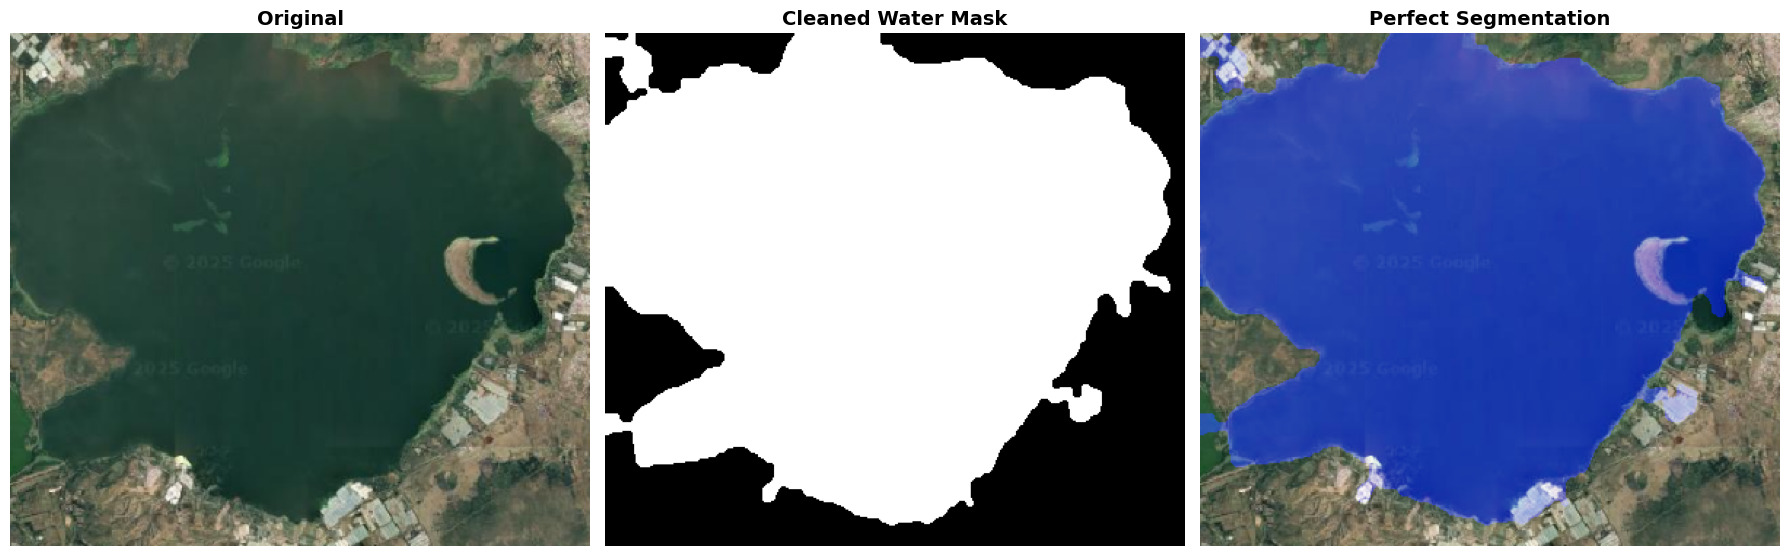

In [ ]:
import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

# Load your trained model
# FIX: Changed model filename to the correct one saved during training
model = keras.models.load_model('/content/drive/MyDrive/water_models/best_water_model.h5', compile=False)

def segment_water_improved(image_path, save_path=None):
    """
    Improved water segmentation with noise removal
    """
    # Load original image
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    h, w = original.shape[:2]

    # Resize for model - MUST MATCH TRAINING SIZE!
    img_resized = cv2.resize(original, (256, 256))  # Changed from 128 to 256
    img_input = np.expand_dims(img_resized.astype(np.float32) / 255.0, 0)

    # Predict water mask
    pred = model.predict(img_input, verbose=0)[0].squeeze()
    water_mask = (pred > 0.5).astype(np.uint8) * 255

    # Resize mask back to original size
    water_mask = cv2.resize(water_mask, (w, h), interpolation=cv2.INTER_LINEAR)

    # ===== CLEAN UP NOISE =====
    # Remove small noise (those black/white speckles)
    kernel = np.ones((5, 5), np.uint8)
    water_mask = cv2.morphologyEx(water_mask, cv2.MORPH_CLOSE, kernel)  # Fill holes
    water_mask = cv2.morphologyEx(water_mask, cv2.MORPH_OPEN, kernel)   # Remove noise

    # Keep only large water bodies (remove tiny specs)
    contours, _ = cv2.findContours(water_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clean_mask = np.zeros_like(water_mask)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:  # Only keep regions larger than 500 pixels
            cv2.drawContours(clean_mask, [contour], -1, 255, -1)

    # Smooth edges
    clean_mask = cv2.GaussianBlur(clean_mask, (5, 5), 0)
    clean_mask = (clean_mask > 127).astype(np.uint8) * 255

    # ===== CREATE OUTPUT =====
    output = original.copy()

    # Create semi-transparent blue overlay
    blue_overlay = original.copy()
    blue_overlay[:, :, 2] = 255  # Full blue channel

    # Blend with smooth mask
    mask_3channel = np.stack([clean_mask] * 3, axis=-1) / 255.0
    output = (original * (1 - mask_3channel * 0.6) + blue_overlay * (mask_3channel * 0.6)).astype(np.uint8)

    # Save
    if save_path:
        output_bgr = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, output_bgr)
        print(f"✅ Saved to: {save_path}")

    return original, clean_mask, output

# Test
image_path = '/content/Screenshot 2025-11-01 035624.png'
original, mask, result = segment_water_improved(image_path, 'water_perfect.jpg')

# Display
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original)
axes[0].set_title('Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Cleaned Water Mask', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(result)
axes[2].set_title('Perfect Segmentation', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [2]:
import tensorflow as tf
from tensorflow import keras

# Load your model
model = keras.models.load_model('/content/drive/MyDrive/water_models/best_water_model.h5', compile=False)

# Get model architecture
config = model.get_config()

# Rebuild model with fixed input layer
from tensorflow.keras import layers

def build_unet_fixed(input_shape=(256, 256, 3)):
    """Rebuild U-Net with compatible config"""

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        return x

    # Use shape instead of batch_shape
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bridge
    b = conv_block(p4, 512)

    # Decoder
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=2, padding="same")(b)
    u1 = layers.Concatenate()([u1, c4])
    c5 = conv_block(u1, 256)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=2, padding="same")(c5)
    u2 = layers.Concatenate()([u2, c3])
    c6 = conv_block(u2, 128)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=2, padding="same")(c6)
    u3 = layers.Concatenate()([u3, c2])
    c7 = conv_block(u3, 64)

    u4 = layers.Conv2DTranspose(32, (2, 2), strides=2, padding="same")(c7)
    u4 = layers.Concatenate()([u4, c1])
    c8 = conv_block(u4, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    return keras.Model(inputs, outputs, name="UNet")

# Build new model
new_model = build_unet_fixed()

# Copy weights from old model
new_model.set_weights(model.get_weights())

# Save in compatible format
new_model.save('/content/water_model_compatible.h5')

print("✅ Model saved in compatible format!")

# Download it
from google.colab import files
files.download('/content/water_model_compatible.h5')

✅ Model saved in compatible format!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>